In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import load_model
from keras import layers
import os
import tensorflow as tf
import datetime
from collections import deque
from keras.callbacks import ModelCheckpoint


In [41]:

df_all = pd.read_csv('NVDA.csv')
df_all.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
df_all['Date'] = pd.to_datetime(df_all['Date'])
df_all = df_all[['Date', 'Close']]

train_df = pd.read_csv('NVDA_train.csv')
train_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df[['Date', 'Close']]
train_df.index = train_df.pop('Date')

test_df = pd.read_csv('NVDA_test.csv')
test_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df = test_df[['Date', 'Close']]
test_df.index = test_df.pop('Date')


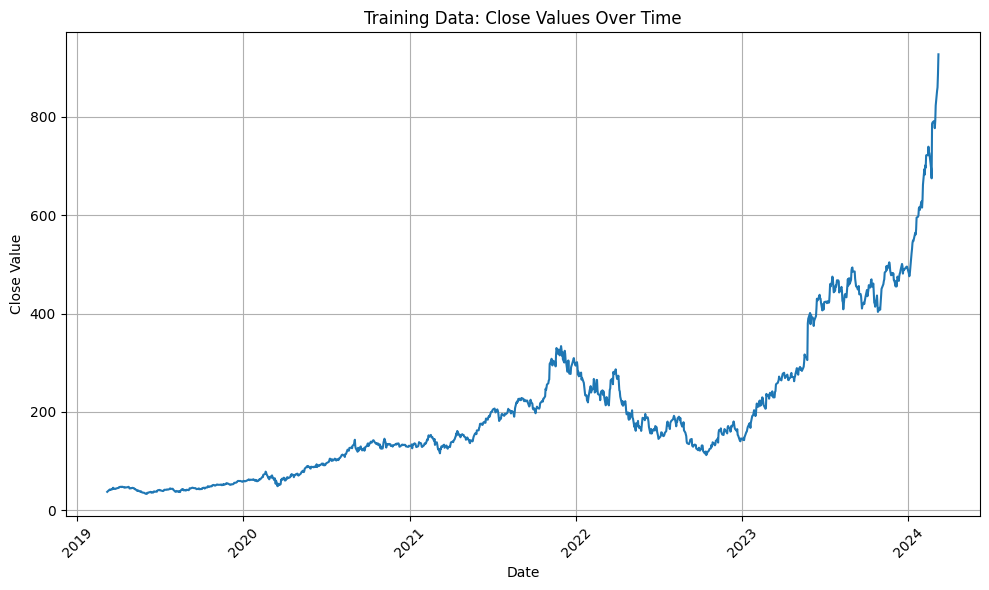

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(df_all['Date'], df_all['Close'], marker='', linestyle='-')
plt.title('Training Data: Close Values Over Time')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# datapreprocessing for lstm

In [39]:

def generate_windowed_dataset(dataframe, start_date_str, end_date_str, column_name, window_size):
    first_date = pd.to_datetime(start_date_str)
    last_date  = pd.to_datetime(end_date_str)

    target_date = first_date
    
    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(window_size+1)
        
        if len(df_subset) != window_size+1:
            print(f'Error: Window of size {window_size} is too large for date {target_date}')
            return

        values = df_subset[column_name].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
        
        if last_time:
            break
            
        target_date = next_date

        if target_date == last_date:
            last_time = True
        
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
    
    X = np.array(X)
    for i in range(0, window_size):
        X[:, i]
        ret_df[f'Target-{window_size-i}'] = X[:, i]
    
    ret_df['Target'] = Y

    return ret_df


# windowed_df = generate_windowed_dataset(train_df, '2021-08-25', '2022-03-23', 'Close', 3)

# windowed_df


In [40]:
def prepare_dataset_for_lstm(windowed_dataframe):
    dates = windowed_dataframe['Target Date'].to_numpy()
    X = windowed_dataframe.iloc[:, 1:-1].to_numpy().reshape(len(windowed_dataframe), -1, 1)
    y = windowed_dataframe['Target'].to_numpy()
    return dates, X.astype(np.float32), y.astype(np.float32)

# LSTM Baseline

## preprocessing

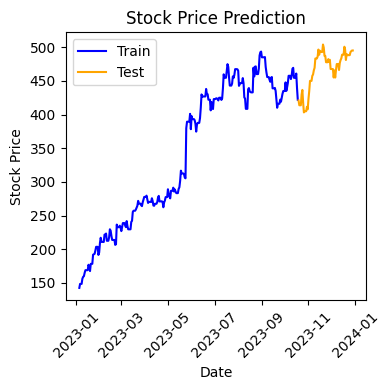

In [7]:
windowed_df = generate_windowed_dataset(train_df, '2023-01-05', '2023-12-29', 'Close', 3)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## training

In [18]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, verbose=0)


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model.save(os.path.join(save_dir, 'baseline.keras'))

## plotting

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


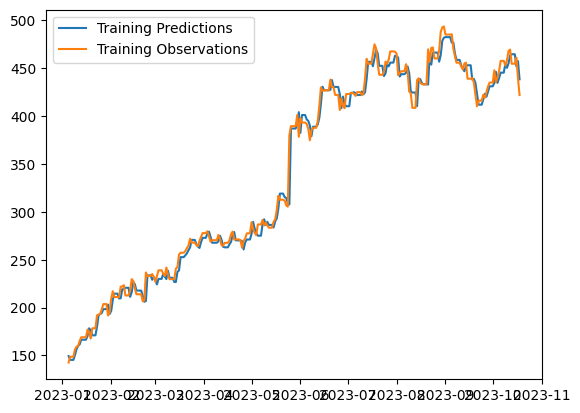

In [19]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


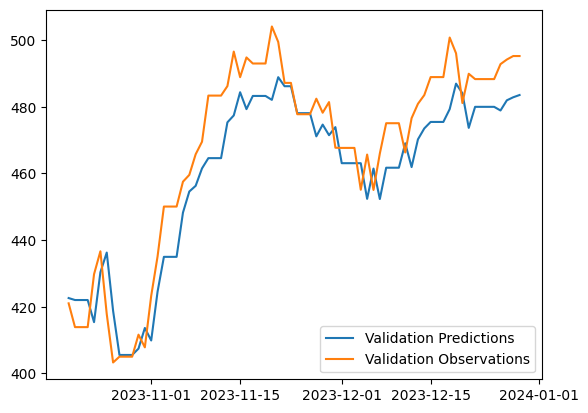

In [20]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

## evaluating on test set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 1270.1593 - mean_absolute_error: 34.1832
Test Loss: 1270.1593017578125
Test Mean Absolute Error: 34.183189392089844
[Timestamp('2024-01-03 00:00:00'), Timestamp('2024-01-04 00:00:00'), Timestamp('2024-01-05 00:00:00'), Timestamp('2024-01-08 00:00:00'), Timestamp('2024-01-09 00:00:00'), Timestamp('2024-01-10 00:00:00'), Timestamp('2024-01-11 00:00:00'), Timestamp('2024-01-12 00:00:00'), Timestamp('2024-01-16 00:00:00'), Timestamp('2024-01-17 00:00:00')]
deque([475.690002, 479.980011, 490.970001], maxlen=3)
[475.690002, 479.980011, 490.970001]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


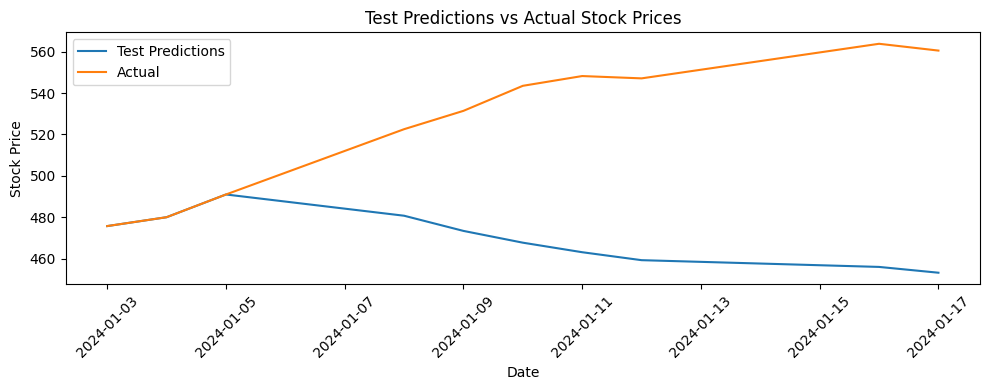

In [21]:
from keras.models import load_model
from keras.optimizers import Adam


model = load_model('trained_models/baseline.keras')


windowed_test_df = generate_windowed_dataset(test_df, '2024-01-05', '2024-01-15', 'Close',3)
dates_test, X_test, y_test = prepare_dataset_for_lstm(windowed_test_df)

# print(dates_test)

loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Mean Absolute Error: {mae}')

n = 10
s = 1


values = test_df[['Close']].iloc[s:s+3].to_numpy().flatten().tolist()
dates = test_df.iloc[s:s+n].index.to_list()

print(dates)


measures = deque(values, maxlen=3)
measures_list = list(measures)

print(measures)
print(measures_list)

for date in range(n-3):
    x = np.array(measures, dtype=float).reshape((1,3,1))
    pred_measure = model.predict(x).flatten()[0]
    measures.append(pred_measure)
    values.append(pred_measure)


plt.figure(figsize=(10, 4))
# plt.plot(df)
plt.plot(dates, values, label='Test Predictions')
plt.plot(dates, test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist(), label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Returns 

In [42]:
train_df = pd.read_csv('NVDA_train.csv')
train_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df[['Date', 'Close']]
train_df.index = train_df.pop('Date')

df_ret_train = train_df
df_ret_train['Return'] = df_ret_train['Close'].pct_change()
df_ret_train.drop(columns=['Close'], inplace=True)
df_ret_train.dropna(inplace=True)


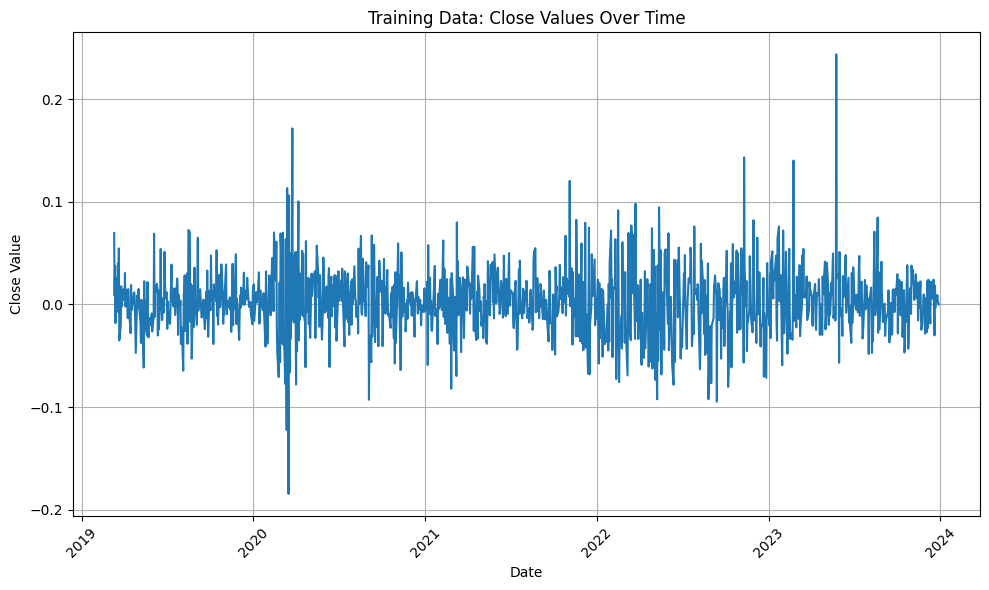

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(df_ret_train.index, df_ret_train['Return'], marker='', linestyle='-')
plt.title('Training Data: Close Values Over Time')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


    Target Date  Target-10  Target-9  Target-8  Target-7  Target-6  Target-5  \
0    2023-01-05  -0.010397  0.025863 -0.070420 -0.008671 -0.071353 -0.006019   
1    2023-01-06   0.025863 -0.070420 -0.008671 -0.071353 -0.006019  0.040396   
2    2023-01-09  -0.070420 -0.008671 -0.071353 -0.006019  0.040396  0.000753   
3    2023-01-10  -0.008671 -0.071353 -0.006019  0.040396  0.000753 -0.020460   
4    2023-01-11  -0.071353 -0.006019  0.040396  0.000753 -0.020460  0.030318   
..          ...        ...       ...       ...       ...       ...       ...   
243  2023-12-22   0.019530 -0.018503  0.022090  0.009044  0.005448  0.011169   
244  2023-12-26  -0.018503  0.022090  0.009044  0.005448  0.011169  0.024279   
245  2023-12-27   0.022090  0.009044  0.005448  0.011169  0.024279 -0.009445   
246  2023-12-28   0.009044  0.005448  0.011169  0.024279 -0.009445 -0.030098   
247  2023-12-29   0.005448  0.011169  0.024279 -0.009445 -0.030098  0.018270   

     Target-4  Target-3  Target-2  Targ

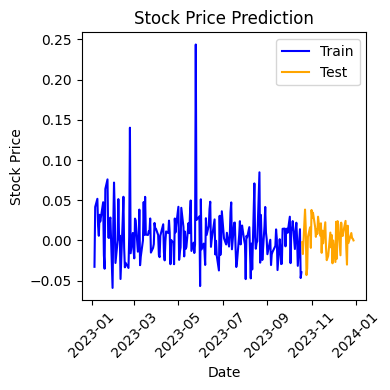

In [77]:
windowed_df = generate_windowed_dataset(df_ret_train, '2023-01-05', '2023-12-29', 'Return', 10)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

print(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Training

In [78]:
model = Sequential([
    layers.Input((10, 1)),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define a ModelCheckpoint callback
checkpoint_path = os.path.join(save_dir, 'return.keras')
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_loss',  # Choose the metric to monitor
                             save_best_only=True,  # Save only the best model
                             mode='min',  # 'min' for validation loss, 'max' for accuracy, 'auto' for automatic
                             verbose=0)

# Train the model with the callback
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=1000,
                    callbacks=[checkpoint], verbose=0)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


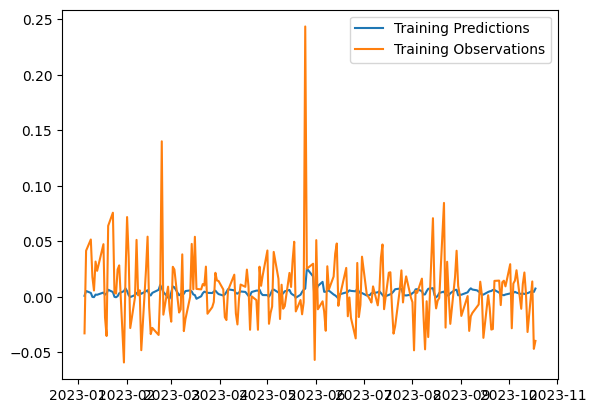

In [75]:
# Load the best model 


return_model = load_model('trained_models/return.keras')
train_predictions = return_model.predict(X_train).flatten()


plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


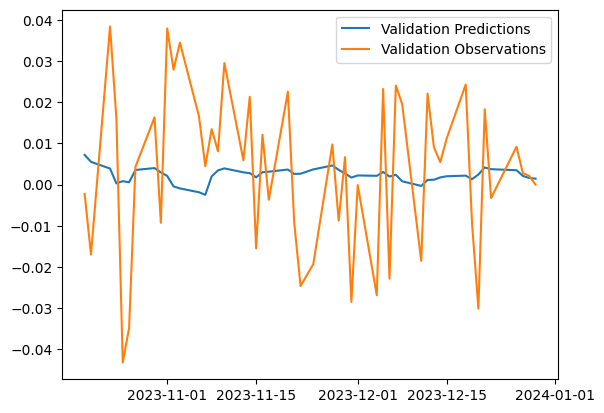

In [83]:
val_predictions = return_model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [85]:
from keras.models import load_model
from keras.optimizers import Adam


model = load_model('trained_models/return.keras')


windowed_test_df = generate_windowed_dataset(test_df, '2024-01-06', '2024-01-15', 'Close',3)
dates_test, X_test, y_test = prepare_dataset_for_lstm(windowed_test_df)

# print(dates_test)

loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Mean Absolute Error: {mae}')

n = 4
s = 1


values = test_df[['Close']].iloc[s:s+3].to_numpy().flatten().tolist()
dates = test_df.iloc[s:s+n].index.to_list()

print(dates)


measures = deque(values, maxlen=3)
measures_list = list(measures)

print(measures)
print(measures_list)

for date in range(n-3):
    x = np.array(measures, dtype=float).reshape((1,3,1))
    pred_measure = 1+model.predict(x).flatten()[0]
    measures.append(pred_measure)
    values.append(pred_measure)


plt.figure(figsize=(10, 4))
# plt.plot(df)
plt.plot(dates, values, label='Test Predictions')
plt.plot(dates, test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist(), label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x103838250>>
Traceback (most recent call last):
  File "/Users/gustavlundberg/Documents/GitHub/LSTM-Neural-Network-for-Stock-Market-prediction/myenv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


# Comments

In [ ]:
# Very bad extrapolation (learn data outside its range), for it to better extrapolate we can train it on a smaller interval closer the dates we actually want to predict
# In most models its good to minmax scale, but not in the case of stock market predictions because there is no maximum value prices are always increasing 
